<a href="https://colab.research.google.com/github/pacificsun/KnowledgeGraph/blob/main/COLING_22_KGEs_for_NLP_Tutorials.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# **Knowledge Graph Embeddings for NLP: From Theory to Practice**
### COLING 2022 Tutorials, October 16th 2022, Sunday
### (Hands-on Session)

# 1. Preliminaries



For this hands-on tutorial, we will be using the open-source library [AmpliGraph](https://github.com/Accenture/AmpliGraph).

Let's start by installing the library and it's dependencies, and then importing the libraries used in this tutorial. 

In [ ]:
# If running on local system execute this cell

# Install CUDA
#! conda install -y cudatoolkit=11.2.2

# Install cudnn libraries
# This library improves the performance of tensorflow, however, we need to give up determinism over speed.
#! conda install cudnn=8.2

# Install tensorflow GPU 
#! pip install tensorflow-gpu==2.9.0

Let us check if tensorflow is correctly installed and if we can access the GPU

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
# Supress tf debugging messages and warnings. Only show tf errors.
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
print('TensorFlow  version: {}'.format(tf.__version__))

# Get the GPU name
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

TensorFlow  version: 2.8.2
Found GPU at: /device:GPU:0


Let's install AmpliGraph and other dependencies

In [ ]:
%%capture 
# Install AmpliGraph library
! pip install git+https://github.com/Accenture/AmpliGraph.git@ampligraph2/develop

# Required to visualize embeddings with tensorboard projector, comment out if not required!
! pip install --user tensorboard

# Required to plot text on embedding clusters, comment out if not required!
! pip install --user git+https://github.com/Phlya/adjustText

In [ ]:
# All imports used in this tutorial 

import ampligraph
import numpy as np
import pandas as pd
import tensorflow as tf

from ampligraph.evaluation import train_test_split_no_unseen, mr_score, mrr_score, hits_at_n_score
from ampligraph.discovery import query_topn, discover_facts, find_clusters
from ampligraph.latent_features import ScoringBasedEmbeddingModel
from ampligraph.utils import save_model, restore_model

print('Ampligraph version: {}'.format(ampligraph.__version__))

Ampligraph version: 2.0-dev


---
# 2. Loading a Knowledge Graph dataset


To begin with we're going to need a knowledge graph, so let's load a standard knowledge graph called ***Freebase-15k-237***. 

Ampligraph provides a set of APIs to [load standard knowledge graphs](https://github.com/Accenture/AmpliGraph). 

Also provided are a set of APIs load csv, ntriples and rdf formats. Details can be found [here](https://github.com/Accenture/AmpliGraph)


In [ ]:
from ampligraph.datasets import load_fb15k_237, load_wn18rr, load_yago3_10

For this tutorial we have remapped the IDs of freebase 237 and created a csv file containing human readable names instead of IDs. 

In [ ]:
import pandas as pd

URL = 'https://ampgraphenc.s3-eu-west-1.amazonaws.com/datasets/freebase-237-merged-and-remapped.csv'
dataset = pd.read_csv(URL, header=None).drop_duplicates()
dataset.columns = ['subject', 'predicate', 'object']
dataset.head(5)

,subject,predicate,object
0,"queens college, city university of new york",/education/educational_institution/students_gr...,carol leifer
1,digital equipment corporation,/business/business_operation/industry,computer hardware
2,/m/0drtv8,/award/award_ceremony/awards_presented./award/...,laurence mark
3,the departed,/award/award_winning_work/awards_won./award/aw...,leonardo dicaprio
4,marilyn manson,/people/person/profession,actor


In [ ]:
print('Total triples in the KG:', dataset.shape)

Total triples in the KG: (308722, 3)



![KG](https://user-images.githubusercontent.com/39597669/90747195-9fc44c80-e2c8-11ea-9f70-097993581bac.png) 

## 2.1 Create training, validation and test splits

Let's use the [`train_test_split_no_unseen`](https://github.com/Accenture/AmpliGraph) function provided by Ampligraph to create the training, validation and test splits. You can specify the size or percentage of triples you want in the test set and the API carves out the triples from the dataset. It ensures that the test and validation splits contains triples whose entities are "seen" during training. 

This API can also be used to get triples from specific predicate types in the test/validation set by using ``filtered_test_predicates`` argument.


In [ ]:
from ampligraph.evaluation import train_test_split_no_unseen
# get the validation set of size 500

test_train, X_valid = train_test_split_no_unseen(dataset.values, 500, seed=0)

# get the test set of size 1000 from the remaining triples
X_train, X_test = train_test_split_no_unseen(test_train, 1000, seed=0)

print('Total triples:', dataset.shape)
print('Size of train:', X_train.shape)
print('Size of valid:', X_valid.shape)
print('Size of test:', X_test.shape)

Total triples: (308722, 3)
Size of train: (307222, 3)
Size of valid: (500, 3)
Size of test: (1000, 3)


## **Key Takeaways**

- `train_test_split_no_unseen` API can be used to generate train/test splits such that test set contains only entities 'seen' during training

---
# 3. Model Training and Evaluation

## 3.1 Model Training

Now that we have split the dataset, let's dive directly into model training. 

Let us create a KGE model and train it using TransE scoring function of 150 dimensions using corruption size of 1 i.e. 1 corruption per train triple.

**TransE** is one of the first embedding models which set the platform for the KGE research. It uses simple vector algebra to score the triples. It has very low number of trainable parameters compared to most models. 

<center>$f = - || s + p - o ||_{n}$</center>

In [ ]:
# Ampligraph 2 follows keras style 
from ampligraph.latent_features import ScoringBasedEmbeddingModel

model = ScoringBasedEmbeddingModel(k=150,                                         # embedding size
                                   eta=1,                                         # number of corruptions to generate during training
                                   scoring_type='TransE',                         # Scoring Function name
                                   seed=0)                                        # Random generator seed

# In Ampligraph, currently we support all initializers, optimizers and regularizers provided by keras
# Just like in keras, we can either pass the names (if we want to use default hyperparameters) or we can create their 
# instances with custom hyperparameters and then pass to model.compile. 
# You can also pass custom functions to these arguments

# Let's create an adam optimizer with customized learning rate =0.001
adam = tf.keras.optimizers.Adam(learning_rate=0.001)

# We dont support the losses provided in keras. We have our own set of losses which are based on 
# learning to rank protocol. These can be found under ampligraph.latent_features
# Let's compile the model with Pairwise loss of custom hyperparameter
# if you want to use default parameter, you can directly specify the name of the loss in compile function
from ampligraph.latent_features import PairwiseLoss
loss= PairwiseLoss(loss_params={'margin': 0.5})

# We will use Glorot uniform and L2 regularizer with their default hyperparameters
model.compile(optimizer=adam,                                                     # optimizer
              loss=loss,                                                          # loss
              entity_relation_initializer='glorot_uniform',                       # initializer
              entity_relation_regularizer='L2')                                   # regularizer


# In Ampligraph2, we also support most of the callbacks provided by keras like Checkpoint, Tensorboard, EarlyStopping, or custom
# Training Logs
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./transe_train_logs')

model.fit(X_train,                                                                # dataset
          batch_size=30000,                                                       # batch size
          epochs=100,                                                             # Num of epochs
          verbose=True,                                                           # verbosity
          callbacks=[tensorboard_callback])

# the training process can be visualized on tensorboard
# This will not work in google colab - only uncomment and run if using jupyter notebook 

# ! tensorboard --logdir='./transe_train_logs'

Epoch 1/100
12/12 [==============================] - 6s 531ms/step - loss: 13546.4678
Epoch 2/100
12/12 [==============================] - 3s 255ms/step - loss: 12985.0811
Epoch 3/100
12/12 [==============================] - 3s 224ms/step - loss: 12369.1123
Epoch 4/100
12/12 [==============================] - 3s 249ms/step - loss: 11669.9326
Epoch 5/100
12/12 [==============================] - 1s 106ms/step - loss: 10913.6416
Epoch 6/100
12/12 [==============================] - 1s 106ms/step - loss: 10140.5127
Epoch 7/100
12/12 [==============================] - 1s 106ms/step - loss: 9385.7432
Epoch 8/100
12/12 [==============================] - 1s 106ms/step - loss: 8688.6162
Epoch 9/100
12/12 [==============================] - 1s 106ms/step - loss: 8070.2246
Epoch 10/100
12/12 [==============================] - 1s 105ms/step - loss: 7530.8892
Epoch 11/100
12/12 [==============================] - 1s 105ms/step - loss: 7060.5464
Epoch 12/100
12/12 [==============================] - 1s 

In [ ]:
# Once we have trained the model, we can save it as follows
from ampligraph.utils import save_model
save_model(model, 'TransE-small')

The path TransE-small already exists. This save operation will overwrite the model                 at the specified path.
WARNING - Found untraced functions such as _get_ranks while saving (showing 1 of 1). These functions will not be directly callable after loading.


For those who are familiar with AmpliGraph 1.x, we have created backward compatible APIs under ``ampligraph.compat`` module. These APIs act as wrappers around the newer keras style APIs and provide seamless experience for our existing user base.

In [ ]:
from ampligraph.compat import TransE

compat_model = TransE(k=150,                                                     # embedding size
               epochs=10,                                                        # Num of epochs
               batches_count= 10,                                                # Number of batches 
               eta=1,                                                            # number of corruptions to generate during training
               loss='pairwise', loss_params={'margin': 0.5},                     # loss type and it's hyperparameters         
               initializer='xavier', initializer_params={'uniform': True},       # initializer type and it's hyperparameters
               regularizer='LP', regularizer_params= {'lambda': 0.01, 'p': 2},   # regularizer along with its hyperparameters
               optimizer= 'adam', optimizer_params= {'lr': 0.001},               # optimizer to use along with its hyperparameters
               seed= 0, verbose=True)

compat_model.fit(X_train)


Epoch 1/10
11/11 [==============================] - 2s 161ms/step - loss: 14925.7090
Epoch 2/10
11/11 [==============================] - 1s 110ms/step - loss: 14355.4033
Epoch 3/10
11/11 [==============================] - 1s 111ms/step - loss: 13730.6709
Epoch 4/10
11/11 [==============================] - 1s 110ms/step - loss: 13032.6895
Epoch 5/10
11/11 [==============================] - 1s 109ms/step - loss: 12269.3154
Epoch 6/10
11/11 [==============================] - 1s 109ms/step - loss: 11476.2598
Epoch 7/10
11/11 [==============================] - 1s 127ms/step - loss: 10680.0469
Epoch 8/10
11/11 [==============================] - 1s 109ms/step - loss: 9914.9238
Epoch 9/10
11/11 [==============================] - 1s 109ms/step - loss: 9216.5703
Epoch 10/10
11/11 [==============================] - 1s 108ms/step - loss: 8598.8389


You can refer [this link](https://github.com/Accenture/AmpliGraph) for detailed explaination of the parameters and their values.

## 3.2 Evaluation metrics


### 3.2.1 Per triple metrics:



This is a metric that is computed for each test set triple:

- **score**: This is the value assigned to a triple, by the model, by applying the scoring function.

Let's look at how we can get the score for a triple of interest and how to interpret it.

In [ ]:
test_triple = [['harrison ford', 
               '/film/actor/film./film/performance/film', 
               'star wars']]

triple_score = model.predict(test_triple) # pass the test triples to model.predict to get a score

print('Triple of interest:\n', test_triple)
print('Triple Score:\n', triple_score)

Triple of interest:
 [['harrison ford', '/film/actor/film./film/performance/film', 'star wars']]
Triple Score:
 [-1.3698515]


But what does this score tell you? Nothing! It is just a value. In order to interpret the score we have 2 options:

1. We can create a list of hypothesis that we want to test, score them and then choose the top n hypothesis as True statements.

2. As described earlier in the theory section, unlike classification task, we are doing a learning to rank task. In order to interpret the score we can generate the corruptions and compare the triple score against the scores of corruptions to see how well does the model rank the test triple against them.


Let's look at the first option. Let us create a list of hypothesis and score them.

In [ ]:
import numpy as np
list_of_actors = ['salma hayek', 'carrie fisher', 'natalie portman',  'kristen bell',
                  'mark hamill',  'harrison ford' ]

# stack it horizontally to create s, p, o
hypothesis = np.column_stack([list_of_actors, 
                              ['/film/actor/film./film/performance/film'] * len(list_of_actors),
                              ['star wars'] * len(list_of_actors),
                             ])

# score the hypothesis
triple_scores = model.predict(hypothesis)

# append the scores column
scored_hypothesis = np.column_stack([hypothesis, triple_scores])
# sort by score in descending order
scored_hypothesis = scored_hypothesis[np.argsort(scored_hypothesis[:, 3])]
scored_hypothesis

array([['mark hamill', '/film/actor/film./film/performance/film',
        'star wars', '-1.0071361'],
       ['harrison ford', '/film/actor/film./film/performance/film',
        'star wars', '-1.3698515'],
       ['natalie portman', '/film/actor/film./film/performance/film',
        'star wars', '-1.3856037'],
       ['salma hayek', '/film/actor/film./film/performance/film',
        'star wars', '-1.4559604'],
       ['carrie fisher', '/film/actor/film./film/performance/film',
        'star wars', '-1.6338433'],
       ['kristen bell', '/film/actor/film./film/performance/film',
        'star wars', '-1.7790042']], dtype='<U39')


- **rank**: For a triple, this metric is computed by generating corruptions and then scoring them and computing the rank(position) of the triple score against the corruptions. The pseudocode and the example illustrates how to compute rank on the test set.

         for each test set triple <s, p, o>:
                 a. Compute the score of the test triple (hypothesis) 
                     hypothesis_score = score(<s, p, o>)
                     
                 b. Generate the subject corruptions 
                         sub_corr = <?, p, o>
                 c. Compute the score of the subject corruptions
                         sub_corr_score = score(sub_corr) 
                 d. Find the position of hypothesis_score in sub_corr_score to get the sub_rank
                   
                 e. Generate the object corruption 
                         obj_corr = <s, p, ?>
                 f. Compute the score of the object corruptions
                         obj_corr_score = score(obj_corr) 
                 g. Find the position of hypothesis_score in obj_corr_score to get the obj_rank
                 
                 h. Return rank = [sub_rank, obj_rank]



![rank example](https://user-images.githubusercontent.com/281477/90627614-14897f00-e214-11ea-8f8e-d57da9888606.png)





The above form of evaluation can be done using the ``evaluate`` function of the ``ScoreBasedEmbeddingModel``

In [ ]:
ranks = model.evaluate(test_triple,                # pass the triples that need to be evaluated 
                       ranking_strategy='worst')   # pass the ranking strategy (strategy that is used to break ties)

print('\nRanks:', ranks)

2/2 [==============================] - 0s 185ms/step

Ranks: [[1443  868]]


There are multiple strategies to compute ranks especially when there are ties. Lets look at each of them in detail with an example. 

Assume there are only 10 corruptions, and assume that all the corruptions get the same score as the test triple. The ranks are as follows 
- Assign the **worst rank** i.e. the test set triple gets a rank of 11. This is followed by most papers in the literature. This is the strictest approach and it drives down the mrr by a large margin if there are many ties. We employ this strategy in AmpliGraph.

<center> $rank = COUNT( corruption_{score} \ge hypothesis_{score} )$ + 1</center>
    
- Assign the **middle rank** i.e. the test set triple gets a rank of 6. We found this strategy being used by [ICLR 2020 paper](https://openreview.net/pdf?id=BkxSmlBFvr). This approach seems to be fair towards the model in resolving the ties as it assigns the middle rank to break ties.

<center> $rank = COUNT( corruption_{score} \gt hypothesis_{score} ) + \dfrac{COUNT( corruption_{score} == hypothesis_{score} )}{2}$ + 1</center>

- Assign the **best rank** i.e. the test set triple gets a rank of 1. This approach is followed by [ConvKB paper](https://arxiv.org/pdf/1712.02121.pdf).  This approach is overly biased and helps the model achieve a very good mrr in case of ties.

<center> $rank = COUNT( corruption_{score} \gt hypothesis_{score} )$ + 1</center>

We recommend the usage of the **worst** strategy (default).

### 3.2.2 Filtered evaluation


While evaluating ([as described earlier](#3.1-Evaluation-metrics)), we generate all the corruptions (using all the unique entities in our dataset) per test triple, score and rank them. While doing so, we are not filtering the true positives - in other words, some of the corruptions may not really be corruptions and may be ground truth triples observed during training. Training triples usually get a high score as they are "observed" by the model. Hence a test triple would get a lower rank if such triples appear in corruptions. To filter out the True Positives (after step b. and e.), one can pass all the True Positive triples  to `filter_triples` parameter of the `evaluate` function. This will perform a **"filtered" evaluation** and return the **"filtered" ranks** adjusted by removing the True Positives from the corruptions. More details for `evaluate` function can be found [here](https://github.com/Accenture/AmpliGraph).


In [ ]:
print('Size of X_test:', X_test.shape)

X_filter = {'train': X_train, 
            'valid': X_valid, 
            'test': X_test}

ranks = model.evaluate(test_triple, 
                       use_filter=X_filter)

print(ranks)

Size of X_test: (1000, 3)
2/2 [==============================] - 1s 393ms/step
[[1434  856]]


One obvious question is why do we append the Valid and Test set to the X_filter. The model has not "observed" them during training. We do so because, we would like to evaluate a test triple against it's corruptions and not against known facts. If we know that the Validation triples and Test triples are facts (and not queries), we need to filter these triples out of the generated corruptions. This is the standard procedure that is used to compute the metrics to compete on the leadership board.

### 3.2.3 Aggregate metrics




Once we have the ranks for all the test set triples, we can compute the following aggregate metrics: **MR**, **MRR**, **Hits@N**. These metrics indicate the overall quality of the model on a test set. These metrics come from Information Retrieval domain and are always computed on a set of **True Statements**. To illustrate each of these metric let us first create a small test set of 5 triples and compute their ranks.

In [ ]:
X_test_small = np.array(
                [['master of arts',
                    '/education/educational_degree/people_with_this_degree./education/education/major_field_of_study',
                    'law'],

                ['world war ii', '/film/film_subject/films',
        'the english patient'],

                ['alfred hitchcock', '/film/director/film', 'family plot'],

                ['the nightmare before christmas', '/film/film/language', 'english language'],
                ['germans', '/people/ethnicity/people', 'jessica biel']])


X_filter = {'train': X_train, 
            'valid': X_valid, 
             'test': X_test, 
}

ranks = model.evaluate(X_test_small, 
                         use_filter=X_filter, 
                         corrupt_side='s,o')
print(ranks)

2/2 [==============================] - 1s 394ms/step
[[   3   24]
 [   3  649]
 [   1   15]
 [   3    1]
 [  74 1979]]


Now let us look at each aggregate metrics in detail:

- **Mean rank (MR)**, as the name indicates, is the average of all the ranks of the triples. The value ranges from 1 (ideal case when all ranks equal to 1) to number of corruptions (where all the ranks are last).

![mr formula](https://user-images.githubusercontent.com/281477/90627586-105d6180-e214-11ea-84d4-c5d3e4b089f4.png)

In [ ]:
from ampligraph.evaluation import mr_score
print('MR :', mr_score(ranks))

MR : 275.2


- **Mean reciprocal rank (MRR)**, is the average of the reciprocal ranks of all the triples. The value ranges from 0 to 1; higher the value better is the model.

![mrr formula](https://user-images.githubusercontent.com/281477/90627604-12272500-e214-11ea-9777-5d30b23f0d6f.png)

In [ ]:
from ampligraph.evaluation import mrr_score
print('MRR :', mrr_score(ranks))

MRR : 0.3123892984606108


MRR is an indicator of mean rank after removing the effect of outliers.

In [ ]:
print('Mean rank after removing the outlier effect: ', np.ceil(1/mrr_score(ranks)))

Mean rank after removing the outlier effect:  4.0


- **hits@n** is the percentage of computed ranks that are greater than (in terms of ranking) or equal to a rank of n. The value ranges from 0 to 1; higher the value better is the model.

![hits formula](https://user-images.githubusercontent.com/281477/90627565-09365380-e214-11ea-81c8-292a3de016d0.png)

In [ ]:
from ampligraph.evaluation import hits_at_n_score
print('hits@1 :', hits_at_n_score(ranks, 1))
print('hits@10 :', hits_at_n_score(ranks, 10))

hits@1 : 0.2
hits@10 : 0.5


**What if, for a model, you observe that on a test set, the MRR score is 0.01? Is it a good model?**

It is not very straightforward. What the above value means is that if you remove the outlier effect, on an average the ranks are around 100 (1/0.01). It may be a good/bad value. It depends on number of corruptions that you have used for the computation. Say you had 1 million corruptions and yet the mrr score was 0.01. The model, in general, was quite good at ranking against 1 million corruption because on an average it gave a rank of close to 100. But say if the corruptions were only 100 and we had an mrr of 0.01, it means that the model did a very bad task at ranking the test triples against just 100 corruptions.

On a real life dataset, on should take a closer look at **hits@n** values and decide whether the model is a good model or not. ***The choice of n should depend on the number of corruptions that are being generated per test triple***. If a large percentage of ranks computed on the test set triple falls within the n ranks, then the model can be considered as a good model.

In [ ]:
# print unique entities
print('Number of unique entities:', model.get_count('e'))

Number of unique entities: 14184


In [ ]:

def display_aggregate_metrics(ranks):
    print('Mean Rank:', mr_score(ranks)) 
    print('Mean Reciprocal Rank:', mrr_score(ranks)) 
    print('Hits@1:', hits_at_n_score(ranks, 1))
    print('Hits@10:', hits_at_n_score(ranks, 10))
    print('Hits@100:', hits_at_n_score(ranks, 100))


display_aggregate_metrics(ranks)


Mean Rank: 275.2
Mean Reciprocal Rank: 0.3123892984606108
Hits@1: 0.2
Hits@10: 0.5
Hits@100: 0.8



## 3.3. Training with early stopping



While training a model, we would like to make sure that the model does not overfit or under fit on the data. If we train a model for a fixed number of epochs, we will not know whether the model has underfit or overfit the training data. Hence it is necessary to test the model performance on a held out set at regular intervals to decide when to stop training. This is called "Early stopping", i.e. we don't let the model run for a long time but stop much before when the performance on the held out set starts to degrade. 

However we also do not want to model to overfit on the held out set and limit the generalization capabilities of the model. Hence we should create both a validation set and a test set to verify the generalization capability of the model, and to make sure that we dont over fit and under fit on the data.  

In [ ]:
# create the model with transe scoring function
model = ScoringBasedEmbeddingModel(eta=1, 
                                   k=100,
                                   scoring_type='TransE',
                                   seed=0)



adam = tf.keras.optimizers.Adam(learning_rate=0.001)

from ampligraph.latent_features import PairwiseLoss
loss= PairwiseLoss(loss_params={'margin': 0.5})

model.compile(optimizer=adam,                                                     # optimizer
              loss=loss,                                                          # loss
              entity_relation_initializer='glorot_uniform',                       # initializer
              entity_relation_regularizer='L2')                                   # regularizer

# Use keras earlystopping callback for early stopping
checkpoint = tf.keras.callbacks.EarlyStopping(monitor="val_mrr", # which metrics to monitor (val_loss, val_mrr, val_mr, val_hist@1, etc)
                                              patience=3,        # If the monitored metric doesnt improve 
                                                                 # for these many checks the model early stops
                                              verbose=1,         # verbosity
                                              mode="max",        # how to compare the monitored metrics. 
                                                                 # max - means higher is better
                                              restore_best_weights=True) # restore the weights with best value

# evaluate the model with filter
X_filter = {'train': X_train, 
            'valid': X_valid, 
            'test': X_test}

model.fit(X_train,
             batch_size=30000,
             epochs=4000,
             validation_data = X_valid,         # Validation data
             validation_batch_size=100,         # Validation batch size
             validation_burn_in=300,            # Burn in time, i.e. early stopping checks will not be performed till 300 epochs
             validation_freq=50,                # After burn in time, early stopping checks will be performed at every 50th epochs (i.e. 150, 200, 250, ...)
             validation_corrupt_side='s,o',     # Which sides to corrupt furing early stopping evaluation (default both subject and obj as described earlier)
             callbacks=[checkpoint])            # Pass the callback to the fit function



ranks = model.evaluate(X_test, 
                       use_filter=X_filter,
                       ranking_strategy='worst')
# display the metrics
display_aggregate_metrics(ranks)

Epoch 1/4000
12/12 [==============================] - 2s 150ms/step - loss: 13629.1523
Epoch 2/4000
12/12 [==============================] - 1s 103ms/step - loss: 13184.7031
Epoch 3/4000
12/12 [==============================] - 1s 100ms/step - loss: 12700.8496
Epoch 4/4000
12/12 [==============================] - 1s 103ms/step - loss: 12153.2959
Epoch 5/4000
12/12 [==============================] - 2s 144ms/step - loss: 11538.4473
Epoch 6/4000
12/12 [==============================] - 1s 103ms/step - loss: 10875.9531
Epoch 7/4000
12/12 [==============================] - 1s 101ms/step - loss: 10199.5801
Epoch 8/4000
12/12 [==============================] - 1s 101ms/step - loss: 9530.8838
Epoch 9/4000
12/12 [==============================] - 1s 100ms/step - loss: 8900.5459
Epoch 10/4000
12/12 [==============================] - 1s 102ms/step - loss: 8330.7871
Epoch 11/4000
12/12 [==============================] - 1s 101ms/step - loss: 7824.3149
Epoch 12/4000
12/12 [========================


## Summary so far

In [ ]:
# ----------------------
# Generate train/test data
# create train/test/valid splits, train the model and evaluate using train_test_split_no_unseen API
from ampligraph.evaluation import train_test_split_no_unseen
# get the validation set of size 500
test_train, X_valid = train_test_split_no_unseen(dataset.values, 500, seed=0)

# get the test set of size 1000 from the remaining triples
X_train, X_test = train_test_split_no_unseen(test_train, 1000, seed=0)
# ----------------------
# Training:

print('Training set:', X_train.shape)

from ampligraph.latent_features import ScoringBasedEmbeddingModel

model = ScoringBasedEmbeddingModel(k=150,                                         # embedding size
                                   eta=1,                                         # number of corruptions to generate during training
                                   scoring_type='TransE',                         # Scoring Function name
                                   seed=0)                                        # Random generator seed

optim = tf.keras.optimizers.Adam(learning_rate=0.001)                             # Optim with custom hyperparams

# compile the model with loss and optimizer
model.compile(optimizer=optim, 
              loss='multiclass_nll',                                              # loss with default hyperparameters
              entity_relation_initializer='glorot_normal',                        # Initializer with default hyperparameters
              entity_relation_regularizer='L2')                                   # Regularizer with default hyperparameters

# In Ampligraph2, we also support most of the callbacks provided by keras like Checkpoint, Tensorboard, EarlyStopping, or custom
# Training Logs
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./transe_train_logs')

# Use keras earlystopping callback for early stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_mrr", # which metrics to monitor (val_loss, val_mrr, val_mr, val_hist@1, etc)
                                              patience=3,        # If the monitored metric doesnt improve 
                                                                 # for these many checks the model early stops
                                              verbose=1,         # verbosity
                                              mode="max",        # how to compare the monitored metrics. 
                                                                 # max - means higher is better
                                              restore_best_weights=True) # restore the weights with best value

# evaluate the model with filter
X_filter = {'train': X_train, 
            'valid': X_valid, 
            'test': X_test}

model.fit(X_train,
             batch_size=30000,
             epochs=4000,
             validation_data = X_valid,         # Validation data
             validation_batch_size=100,         # Validation batch size
             validation_burn_in=300,            # Burn in time, i.e. early stopping checks will not be performed till 300 epochs
             validation_freq=50,                # After burn in time, early stopping checks will be performed at every 50th epochs (i.e. 150, 200, 250, ...)
             validation_corrupt_side='s,o',     # Which sides to corrupt furing early stopping evaluation (default both subject and obj as described earlier)
             callbacks=[early_stop, 
                        tensorboard_callback])  # Pass the callback to the fit function

# save and restore model
from ampligraph.utils import save_model, restore_model
save_model(model, 'TransE')
model = restore_model('TransE')

# Evaluate: 
# Filtered evaluation with ranking strategy assigning worst rank to break ties
ranks = model.evaluate(X_test, 
                       use_filter=X_filter,
                       ranking_strategy='worst')

# ranks are computed per triple
print('Test set:', X_test.shape)
print('Size of ranks:', ranks.shape)

# Aggregate metrics show the aggregate performance of the model on the test set using a single number
from ampligraph.evaluation import mr_score, mrr_score, hits_at_n_score
print('Mean Rank:', mr_score(ranks)) 
print('Mean Reciprocal Rank:', mrr_score(ranks)) 
print('Hits@1:', hits_at_n_score(ranks, 1))
print('Hits@10:', hits_at_n_score(ranks, 10))
print('Hits@100:', hits_at_n_score(ranks, 100))
# ----------------------

## **Key Takeaways**
- `train_test_split_no_unseen` API can be used to generate train/test splits such that test set contains only entities 'seen' during training
- Once a model is trained, one can use `model.predict` to choose from a set of hypothesis based on the scores returned by the model.
- One can access the quality of model on a **test set of True Facts** by using metrics such as MR, MRR and hits@n
- We can use early stopping to prevent model from over/under fitting by using a Validation Set.

# 4. Practical evaluation protocols

Standard protocols, as described earlier, follow a very strict way of evaluating the test set. We corrupt both the subject and object sides with all the entities present in the KG. Also, when the KG is huge with millions of entities, the standard protocol is not feisible. Due to the large number of corruptions, some of which may be semantically incorrect, it becomes a difficult task for the model while ranking and it may lead to misleading metrics. Hence the standard protocol is not recommended for large KGs. 

Let's now look at some practical ways of evaluating for large KGs.



## 4.1 Evaluating by corrupting specific sides
Let's assume that our test set is made up of triples of type <movie, film_language, language_category> and we want to find if our model can correctly find the language of the movie.

In [ ]:
X_test_movie_languages = X_test[X_test[:, 1] == '/film/film/language']
X_test_movie_languages

array([['the reader', '/film/film/language', 'english language'],
       ['blade runner', '/film/film/language', 'hungarian language'],
       ['battle of britain', '/film/film/language', 'english language'],
       ['titanic', '/film/film/language', 'german language'],
       ['the go-between', '/film/film/language', 'english language'],
       ['the nightmare before christmas', '/film/film/language',
        'english language'],
       ['requiem for a dream', '/film/film/language', 'english language'],
       ['the english patient', '/film/film/language', 'english language']],
      dtype=object)

With the evaluation shown below, we are using all entities in our dataset and corrupting both subject and object sides of the test triple and returning 2 ranks.

In [ ]:
ranks = model.evaluate(X_test_movie_languages, 
                             use_filter=X_filter)

display_aggregate_metrics(ranks)
print('\nSize of test set:', X_test_movie_languages.shape)
print('Size of ranks:', ranks.shape)

2/2 [==============================] - 1s 431ms/step
Mean Rank: 209.75
Mean Reciprocal Rank: 0.20174460273657502
Hits@1: 0.125
Hits@10: 0.4375
Hits@100: 0.75

Size of test set: (8, 3)
Size of ranks: (8, 2)


This is because [model.evaluate](https://github.com/Accenture/AmpliGraph) with default protocol does the following:
- computes rank by corrupting the subject side (`'s'`) 
- computes rank by corrupting the object side (`'o'`) 
- returns both the ranks per triple.

The metrics (such as mrr, mr, hits@n) are computed by flattening and averaging the ranks.

This is the standard protocol that is usually followed while doing graph completion and is usually adopted for computing the metrics (on traditional datasets like freebase or wordnet) while competing on the leadership board.

If we want to corrupt specific sides (to suit our use-case), we can do so by passing `corrupt_side` parameter to `model.evaluate`. It can take on the following values:
- `s` for subject corruption only
- `o` for object corruption only
- `s+o` for subject and object corruption. Returns a single rank.
- `s,o` for subject and object corruption separately (default). Returns 2 ranks. This is equivalent to calling `model.evaluate` twice with `s` and `o`.


In [ ]:
ranks = model.evaluate(X_test_movie_languages, 
                             use_filter=X_filter,
                             corrupt_side='o')

display_aggregate_metrics(ranks)
print('\nSize of test set:', X_test_movie_languages.shape)
print('Size of ranks:', ranks.shape)

2/2 [==============================] - 1s 421ms/step
Mean Rank: 18.5
Mean Reciprocal Rank: 0.3260597041847042
Hits@1: 0.25
Hits@10: 0.625
Hits@100: 1.0

Size of test set: (8, 3)
Size of ranks: (8, 1)


As you see, only 1 rank is returned per triple, and this rank is the rank obtained by corrupting only the specified side with all the entities in the KG.

## 4.2 Evaluating against a subset of entities

Depending on the use case or size of the graph, you may want to evaluate the test set by generating corruptions only from a subset of entities. This can be done by using `entities_subset` argument. For example, let's say we are doing a genetic study using KG. The graph may have different entity types like patient, diseases, genes, mutations, co-morbidities,ect. Say we want to find out what mutations cause disease i.e. `< ?, causes, disease_name>`. For this use case it doesnt make sense to replace the placeholder with all the entities. A logical replacement would be by using all the mutations.

Similarly for our use case, we are interested in finding the language of the movie. So it makes sense to use only language categories to generate the corruptions for the object side. It also makes the task easier for the model.

In [ ]:
print('The number of corruptions generated per triple is:', model.get_count('e'))

The number of corruptions generated per triple is: 14184


In [ ]:
unique_languages = set(X_train[X_train[:, 1] == '/film/film/language'][:, 2])

print('Number of languages in KG:', len(unique_languages))
print('\n', unique_languages)

Number of languages in KG: 61

 {'german language', 'urdu language', 'khmer language', 'polish language', 'chinese language', 'american english', 'sinhala language', 'ukrainian language', 'portuguese language', 'filipino language', 'bulgarian language', 'romanian language', 'hungarian language', 'dutch language', 'turkish language', 'french', 'finnish language', 'irish', 'punjabi language', 'malay language', 'vietnamese language', 'indonesian language', 'standard chinese', 'cantonese', 'greek language', 'persian language', 'norwegian language', 'england', 'silent film', 'japanese language', 'spanish language', 'afrikaans language', 'serbo-croatian language', 'swahili language', 'korean language', 'hindi language', 'czech language', 'welsh language', 'latin language', 'hebrew language', 'italian food', 'bengali language', 'thai language', 'serbian language', 'russian language', 'danish language', 'italian language', 'yue chinese', 'mandarin chinese', 'german food', 'france', 'croatian l

In [ ]:
ranks = model.evaluate(X_test_movie_languages, 
                             use_filter=X_filter,
                             corrupt_side='o',
                             entities_subset=list(unique_languages))

display_aggregate_metrics(ranks)

2/2 [==============================] - 1s 409ms/step
Mean Rank: 11.125
Mean Reciprocal Rank: 0.33147644927536235
Hits@1: 0.25
Hits@10: 0.625
Hits@100: 1.0


Usually, we can see a drastic increase in the metric values mainly because we are using fewer **semantically "valid" corruptions**. 

When we have a schema for our KG, and the focus is not just graph completion but a specific use case (Eg: similar job search, product recommendation, gene discovery to target a disease, etc), we would  recommend using semantically "valid" corruptions by looking at the schema to do performance evaluation. 

## **Key Takeaways**
- During default evaluation, the `model.evaluate` API corrupts both subject and object side with ALL the entities in the KG and returns 2 ranks. This is a hard task for the model and the resulting metrics may mislead the user. 
- Depending on use case, we can corrupt specific sides of the triples by specifying the `corrupt_side` argument; and we can also provide semantically valid entities to be used for generating corruptions by using the `entities_subset` argument in `model.evaluate` API


---
# 5. Role of scoring functions and their hyperparameters

## 5.1 Role of scoring function

In [ ]:
from ampligraph.latent_features import ScoringBasedEmbeddingModel

### 5.1.1 TransE
This is one of the first embedding models which set the platform for the KGE research. It is quite good at capturing asymmetric relations. It uses simple vector algebra to score the triples. It has very low number of trainable parameters compared to most models. 

<center>$f = - || s + p - o ||_{n}$</center>


In [ ]:
model = ScoringBasedEmbeddingModel(k=150,                                         # embedding size
                                   eta=10,                                         # number of corruptions to generate during training
                                   scoring_type='TransE',                         # Scoring Function name
                                   seed=0)                                        # Random generator seed

optim = tf.keras.optimizers.Adam(learning_rate=0.001)

# compile the model with loss and optimizer
model.compile(optimizer=optim, 
              loss='multiclass_nll',
              entity_relation_initializer='glorot_normal',
              entity_relation_regularizer='L2')


model.fit(X_train,
          batch_size=30000,
          epochs=10)

ranks = model.evaluate(X_test, 
                             use_filter=X_filter,
                             corrupt_side='s,o',
                             ranking_strategy='worst')
display_aggregate_metrics(ranks)

Epoch 1/10
12/12 [==============================] - 2s 183ms/step - loss: 66511.3828
Epoch 2/10
12/12 [==============================] - 1s 119ms/step - loss: 65871.8906
Epoch 3/10
12/12 [==============================] - 1s 118ms/step - loss: 65139.2891
Epoch 4/10
12/12 [==============================] - 1s 117ms/step - loss: 64292.6641
Epoch 5/10
12/12 [==============================] - 1s 118ms/step - loss: 63344.9648
Epoch 6/10
12/12 [==============================] - 1s 118ms/step - loss: 62325.1133
Epoch 7/10
12/12 [==============================] - 1s 119ms/step - loss: 61262.5117
Epoch 8/10
12/12 [==============================] - 1s 118ms/step - loss: 60180.0742
Epoch 9/10
12/12 [==============================] - 1s 118ms/step - loss: 59095.7891
Epoch 10/10
33/33 [==============================] - 12s 364ms/step
Mean Rank: 1569.2875
Mean Reciprocal Rank: 0.10999275629076084
Hits@1: 0.0645
Hits@10: 0.199
Hits@100: 0.45


In [ ]:
out = model.get_train_embedding_matrix_size()
print('Size of entity embeddings:', out['e'])
print('Size of rel embeddings:', out['r'])

Size of entity embeddings: (14184, 150)
Size of rel embeddings: (237, 150)


### 5.1.2 DistMult

This model is quite good at capturing symmetric relations in the graph. It does multiplication of vectors to compute the score. DistMult also has same number of parameters as TransE. 

<center>$f = \sum s * p * o$</center>

Example: \< Jack Likes VideoGames \> \< VideoGames Likes Jack \>

In [ ]:
model = ScoringBasedEmbeddingModel(k=150,                                         # embedding size
                                   eta=10,                                        # number of corruptions to generate during training
                                   scoring_type='DistMult',                       # Scoring Function name
                                   seed=0)                                        # Random generator seed

optim = tf.keras.optimizers.Adam(learning_rate=0.001)

# compile the model with loss and optimizer
model.compile(optimizer=optim, 
              loss='multiclass_nll',
              entity_relation_initializer='glorot_normal',
              entity_relation_regularizer='L2')


model.fit(X_train,
          batch_size=30000,
          epochs=10)

ranks = model.evaluate(X_test, 
                             use_filter=X_filter,
                             corrupt_side='s,o',
                             ranking_strategy='worst')
display_aggregate_metrics(ranks)

Epoch 1/10
12/12 [==============================] - 3s 226ms/step - loss: 66975.6250
Epoch 2/10
12/12 [==============================] - 1s 118ms/step - loss: 66973.2656
Epoch 3/10
12/12 [==============================] - 1s 118ms/step - loss: 66969.0469
Epoch 4/10
12/12 [==============================] - 1s 118ms/step - loss: 66958.8125
Epoch 5/10
12/12 [==============================] - 1s 119ms/step - loss: 66934.7422
Epoch 6/10
12/12 [==============================] - 1s 120ms/step - loss: 66884.2422
Epoch 7/10
12/12 [==============================] - 1s 118ms/step - loss: 66789.4297
Epoch 8/10
12/12 [==============================] - 1s 119ms/step - loss: 66627.2500
Epoch 9/10
12/12 [==============================] - 1s 117ms/step - loss: 66370.7500
Epoch 10/10
33/33 [==============================] - 8s 252ms/step
Mean Rank: 477.7025
Mean Reciprocal Rank: 0.21940122497595463
Hits@1: 0.1485
Hits@10: 0.36
Hits@100: 0.6245


In [ ]:
out = model.get_train_embedding_matrix_size()
print('Size of entity embeddings:', out['e'])
print('Size of entity embeddings:', out['r'])

Size of entity embeddings: (14184, 150)
Size of entity embeddings: (237, 150)


### 5.1.3 Complex

The scoring function can handle symmetry and anti-symmetry quite well.

<center>$f = Re(w_r) * \biggl(Re(e_s) * Re(e_o) + Im(e_s) * Im(e_o) \biggl) + Im(w_r) * \biggl(Re(e_s) * Im(e_o) - Im(e_s) * Re(e_o) \biggl) $</center>

- For symmertic relations, $Im(W_r) == 0$
- For asymmertic relations, $Im(W_r) != 0$. When subject and objects are interchanged (substitute $e_s$ by $e_o$ and $e_o$ by $e_s$) the first term remains constant, but the second term ensures that either one of the two triples get a higher score and the other gets a lower score (due to the negative sign)

In [ ]:
model = ScoringBasedEmbeddingModel(k=150,                                         # embedding size
                                   eta=10,                                        # number of corruptions to generate during training
                                   scoring_type='ComplEx',                       # Scoring Function name
                                   seed=0)                                        # Random generator seed

optim = tf.keras.optimizers.Adam(learning_rate=0.001)

# compile the model with loss and optimizer
model.compile(optimizer=optim, 
              loss='multiclass_nll',
              entity_relation_initializer='glorot_normal',
              entity_relation_regularizer='L2')


model.fit(X_train,
          batch_size=30000,
          epochs=10)

ranks = model.evaluate(X_test, 
                             use_filter=X_filter,
                             corrupt_side='s,o',
                             ranking_strategy='worst')
display_aggregate_metrics(ranks)

Epoch 1/10
12/12 [==============================] - 3s 238ms/step - loss: 66979.1016
Epoch 2/10
12/12 [==============================] - 2s 159ms/step - loss: 66973.9141
Epoch 3/10
12/12 [==============================] - 2s 158ms/step - loss: 66963.9375
Epoch 4/10
12/12 [==============================] - 2s 159ms/step - loss: 66938.2422
Epoch 5/10
12/12 [==============================] - 2s 156ms/step - loss: 66876.3672
Epoch 6/10
12/12 [==============================] - 2s 158ms/step - loss: 66745.9922
Epoch 7/10
12/12 [==============================] - 2s 156ms/step - loss: 66503.1250
Epoch 8/10
12/12 [==============================] - 2s 155ms/step - loss: 66094.2969
Epoch 9/10
12/12 [==============================] - 2s 159ms/step - loss: 65462.2617
Epoch 10/10
33/33 [==============================] - 9s 282ms/step
Mean Rank: 454.4125
Mean Reciprocal Rank: 0.21764507052064044
Hits@1: 0.1495
Hits@10: 0.3555
Hits@100: 0.617


In [ ]:
out = model.get_train_embedding_matrix_size()
print('Size of entity embeddings:', out['e'])
print('Size of entity embeddings:', out['r'])

Size of entity embeddings: (14184, 300)
Size of entity embeddings: (237, 300)


## 5.2 Role of Hyperparameters

A large value of ***k*** may result in overfitting, and the size of the embeddings on the disk would also be large. It may also happen that the embedding matrix may not even fit on the GPU.

In [ ]:

model = ScoringBasedEmbeddingModel(k=1000,                               # embedding size
                                   eta=1,                                # number of corruptions to generate during training
                                   scoring_type='TransE',                # Scoring Function name
                                   seed=0)                               # Random generator seed

optim = tf.keras.optimizers.Adam(learning_rate=0.001)

# compile the model with loss and optimizer
model.compile(optimizer=optim, 
              loss='multiclass_nll',
              entity_relation_initializer='glorot_normal',
              entity_relation_regularizer='L2')                          # use regularizers to prevent overfitting


model.fit(X_train,
          batch_size=30000,                                              # when using large k use smaller batch sizes
          epochs=50)

ranks = model.evaluate(X_test, 
                             use_filter=X_filter,
                             corrupt_side='s,o',
                             ranking_strategy='worst')
display_aggregate_metrics(ranks)

Epoch 1/50
12/12 [==============================] - 2s 176ms/step - loss: 18839.6895
Epoch 2/50
12/12 [==============================] - 1s 119ms/step - loss: 18164.1133
Epoch 3/50
12/12 [==============================] - 1s 120ms/step - loss: 17447.8203
Epoch 4/50
12/12 [==============================] - 1s 119ms/step - loss: 16681.6934
Epoch 5/50
12/12 [==============================] - 1s 119ms/step - loss: 15895.6484
Epoch 6/50
12/12 [==============================] - 1s 118ms/step - loss: 15123.2354
Epoch 7/50
12/12 [==============================] - 1s 117ms/step - loss: 14394.6865
Epoch 8/50
12/12 [==============================] - 1s 118ms/step - loss: 13722.1689
Epoch 9/50
12/12 [==============================] - 1s 117ms/step - loss: 13106.7207
Epoch 10/50
12/12 [==============================] - 1s 117ms/step - loss: 12546.6104
Epoch 11/50
12/12 [==============================] - 1s 118ms/step - loss: 12036.9941
Epoch 12/50
12/12 [==============================] - 1s 119ms/s

A small ***k*** may result in underfitting.

In [ ]:
model = ScoringBasedEmbeddingModel(k=10,                                  # embedding size
                                   eta=1,                                 # number of corruptions to generate during training
                                   scoring_type='TransE',                 # Scoring Function name
                                   seed=0)                                # Random generator seed

optim = tf.keras.optimizers.Adam(learning_rate=0.001)

# compile the model with loss and optimizer
model.compile(optimizer=optim, 
              loss='multiclass_nll',
              entity_relation_initializer='glorot_normal',
              entity_relation_regularizer='L2')


model.fit(X_train,
          batch_size=100000,                                              # Larger batch sizes work with small k
          epochs=50)

ranks = model.evaluate(X_test, 
                         use_filter=X_filter,
                         corrupt_side='s,o',
                         ranking_strategy='worst')
display_aggregate_metrics(ranks)

Epoch 1/50
5/5 [==============================] - 2s 367ms/step - loss: 53210.4453
Epoch 2/50
5/5 [==============================] - 1s 235ms/step - loss: 53135.9609
Epoch 3/50
5/5 [==============================] - 1s 230ms/step - loss: 53062.4727
Epoch 4/50
5/5 [==============================] - 1s 229ms/step - loss: 52989.1094
Epoch 5/50
5/5 [==============================] - 1s 230ms/step - loss: 52913.9297
Epoch 6/50
5/5 [==============================] - 1s 229ms/step - loss: 52836.4961
Epoch 7/50
5/5 [==============================] - 1s 236ms/step - loss: 52756.3359
Epoch 8/50
5/5 [==============================] - 1s 230ms/step - loss: 52673.1719
Epoch 9/50
5/5 [==============================] - 1s 236ms/step - loss: 52585.9844
Epoch 10/50
5/5 [==============================] - 1s 234ms/step - loss: 52494.5938
Epoch 11/50
5/5 [==============================] - 1s 235ms/step - loss: 52399.1289
Epoch 12/50
5/5 [==============================] - 1s 232ms/step - loss: 52299.4414
E

Ideally, you should choose a ***k*** which is large enough, along with a proper choice of ***eta***. 

It has been observed that the performance of model increases with increase in ***eta*** up to a certain point and then saturates. Usually a good value for eta is between 20-30. [add reference]()

In [ ]:
model = ScoringBasedEmbeddingModel(k=300,                             # embedding size
                                   eta=30,                            # number of corruptions to generate during training
                                   scoring_type='TransE',             # Scoring Function name
                                   seed=0)                            # Random generator seed

optim = tf.keras.optimizers.Adam(learning_rate=0.001)

# compile the model with loss and optimizer
model.compile(optimizer=optim, 
              loss='multiclass_nll',
              entity_relation_initializer='glorot_normal',
              entity_relation_regularizer='L2')                       # Make use of regularizer


model.fit(X_train,  
          batch_size=30000,                                           # Play around with batch size to fit on GPU
          epochs=50)

ranks = model.evaluate(X_test, 
                             use_filter=X_filter,
                             corrupt_side='s,o',
                             ranking_strategy='worst')
display_aggregate_metrics(ranks)

Epoch 1/50
12/12 [==============================] - 3s 248ms/step - loss: 95184.0547
Epoch 2/50
12/12 [==============================] - 2s 179ms/step - loss: 94154.4375
Epoch 3/50
12/12 [==============================] - 2s 185ms/step - loss: 92957.3984
Epoch 4/50
12/12 [==============================] - 2s 181ms/step - loss: 91583.2031
Epoch 5/50
12/12 [==============================] - 2s 179ms/step - loss: 90075.2812
Epoch 6/50
12/12 [==============================] - 2s 181ms/step - loss: 88484.5312
Epoch 7/50
12/12 [==============================] - 2s 178ms/step - loss: 86856.0859
Epoch 8/50
12/12 [==============================] - 2s 176ms/step - loss: 85220.3672
Epoch 9/50
12/12 [==============================] - 2s 175ms/step - loss: 83597.0938
Epoch 10/50
12/12 [==============================] - 2s 183ms/step - loss: 82001.9766
Epoch 11/50
12/12 [==============================] - 2s 177ms/step - loss: 80442.5938
Epoch 12/50
12/12 [==============================] - 2s 178ms/s


## 5.3 Grid Search and Random Search

Ampligraph provides an API to perform model selection and to run experimental campaigns on datasets. One can use [select_best_model_ranking](https://docs.ampligraph.org/en/1.4.0/generated/ampligraph.evaluation.select_best_model_ranking.html#ampligraph.evaluation.select_best_model_ranking) to perform model selection. It supports grid search and random search.


In [ ]:
from ampligraph.evaluation import select_best_model_ranking
from ampligraph.compat import TransE

model_class = TransE
param_grid = {
                     "batches_count": [5],
                     "seed": 0,
                     "epochs": [10],
                     "k": [100, 50],
                     "eta": [1, 5],
                     "loss": ["multiclass_nll"],
                     "loss_params": {},
                     "embedding_model_params": {},
                     "regularizer": ["LP"],
                     "regularizer_params": {
                         "p": [3],
                         "lambda": [1e-3]
                      },
                     "optimizer": ["adam"],
                     "optimizer_params":{
                         'lr': lambda: np.random.uniform(0.00001, 0.01)
                     },
                     "verbose": True
                 }
best_model, best_params, best_mrr_train, ranks_test, mrr_test, experimental_history = \
        select_best_model_ranking(model_class, 
                                  X_train, 
                                  X_valid, 
                                  X_test, 
                                  param_grid,
                                  max_combinations=4, # performs random search-executes 2 models by randomly choosing params
                                  use_filter=True,
                                  verbose=True,
                                  use_test_for_selection=True,
                                  early_stopping=True)

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/10
6/6 [==============================] - 2s 361ms/step - loss: 107432.4375
Epoch 2/10
6/6 [==============================] - 1s 213ms/step - loss: 103025.6875
Epoch 3/10
6/6 [==============================] - 1s 211ms/step - loss: 98257.4453
Epoch 4/10
6/6 [==============================] - 1s 210ms/step - loss: 93446.4297
Epoch 5/10
6/6 [==============================] - 1s 214ms/step - loss: 88785.9062
Epoch 6/10
6/6 [==============================] - 1s 208ms/step - loss: 84362.9609
Epoch 7/10
6/6 [==============================] - 1s 207ms/step - loss: 80228.2734
Epoch 8/10
6/6 [==============================] - 1s 206ms/step - loss: 76399.1094
Epoch 9/10
6/6 [==============================] - 1s 206ms/step - loss: 72868.8594
Epoch 10/10
11/11 [==============================] - 7s 675ms/step


 25%|██▌       | 1/4 [00:51<02:33, 51.08s/it]

Epoch 1/10
6/6 [==============================] - 2s 316ms/step - loss: 108695.4531
Epoch 2/10
6/6 [==============================] - 1s 202ms/step - loss: 106396.5859
Epoch 3/10
6/6 [==============================] - 1s 205ms/step - loss: 103786.9609
Epoch 4/10
6/6 [==============================] - 1s 200ms/step - loss: 101018.6328
Epoch 5/10
6/6 [==============================] - 1s 204ms/step - loss: 98187.9375
Epoch 6/10
6/6 [==============================] - 1s 201ms/step - loss: 95352.7422
Epoch 7/10
6/6 [==============================] - 1s 208ms/step - loss: 92564.7422
Epoch 8/10
6/6 [==============================] - 1s 208ms/step - loss: 89852.0391
Epoch 9/10
6/6 [==============================] - 1s 205ms/step - loss: 87227.6172
Epoch 10/10
11/11 [==============================] - 7s 660ms/step


 50%|█████     | 2/4 [01:37<01:36, 48.23s/it]

Epoch 1/10
6/6 [==============================] - 2s 316ms/step - loss: 108415.6719
Epoch 2/10
6/6 [==============================] - 1s 204ms/step - loss: 105618.8516
Epoch 3/10
6/6 [==============================] - 1s 205ms/step - loss: 102498.6797
Epoch 4/10
6/6 [==============================] - 1s 204ms/step - loss: 99242.0859
Epoch 5/10
6/6 [==============================] - 1s 201ms/step - loss: 95961.9922
Epoch 6/10
6/6 [==============================] - 1s 205ms/step - loss: 92724.8750
Epoch 7/10
6/6 [==============================] - 1s 201ms/step - loss: 89583.4922
Epoch 8/10
6/6 [==============================] - 1s 203ms/step - loss: 86562.8125
Epoch 9/10
6/6 [==============================] - 1s 203ms/step - loss: 83672.5078
Epoch 10/10
11/11 [==============================] - 7s 662ms/step


 75%|███████▌  | 3/4 [02:23<00:47, 47.40s/it]

Epoch 1/10
6/6 [==============================] - 2s 311ms/step - loss: 106725.1250
Epoch 2/10
6/6 [==============================] - 1s 207ms/step - loss: 101163.7656
Epoch 3/10
6/6 [==============================] - 1s 203ms/step - loss: 95334.6328
Epoch 4/10
6/6 [==============================] - 1s 209ms/step - loss: 89630.5312
Epoch 5/10
6/6 [==============================] - 1s 206ms/step - loss: 84263.7266
Epoch 6/10
6/6 [==============================] - 2s 254ms/step - loss: 79301.5078
Epoch 7/10
6/6 [==============================] - 1s 206ms/step - loss: 74777.0078
Epoch 8/10
6/6 [==============================] - 1s 205ms/step - loss: 70684.8984
Epoch 9/10
6/6 [==============================] - 1s 203ms/step - loss: 66991.8906
Epoch 10/10
11/11 [==============================] - 7s 670ms/step


100%|██████████| 4/4 [03:10<00:00, 47.53s/it]


11/11 [==============================] - 7s 667ms/step


In [ ]:
print('MRR of the best model:', best_mrr_train)

MRR of the best model: 0.13746530284231187


In [ ]:
# params of the best model
best_params

{'batches_count': 5,
 'seed': 0,
 'epochs': 10,
 'k': 100,
 'eta': 5,
 'loss': 'multiclass_nll',
 'loss_params': {},
 'embedding_model_params': {},
 'regularizer': 'LP',
 'regularizer_params': {'p': 3, 'lambda': 0.001},
 'optimizer': 'adam',
 'optimizer_params': {'lr': 0.008918812277812977},
 'verbose': True}

You can also look at the experimental history and check the various combinations tested during the model selection, along with the results for each combination, using the experimental history.

In [ ]:
experimental_history

[{'model_name': 'TransE',
  'model_params': {'batches_count': 5,
   'seed': 0,
   'epochs': 10,
   'k': 100,
   'eta': 5,
   'loss': 'multiclass_nll',
   'loss_params': {},
   'embedding_model_params': {},
   'regularizer': 'LP',
   'regularizer_params': {'p': 3, 'lambda': 0.001},
   'optimizer': 'adam',
   'optimizer_params': {'lr': 0.00715474177006047},
   'verbose': True},
  'results': {'mrr': 0.1323805468351805,
   'mr': 934.9255,
   'hits_1': 0.077,
   'hits_3': 0.138,
   'hits_10': 0.2405}},
 {'model_name': 'TransE',
  'model_params': {'batches_count': 5,
   'seed': 0,
   'epochs': 10,
   'k': 50,
   'eta': 5,
   'loss': 'multiclass_nll',
   'loss_params': {},
   'embedding_model_params': {},
   'regularizer': 'LP',
   'regularizer_params': {'p': 3, 'lambda': 0.001},
   'optimizer': 'adam',
   'optimizer_params': {'lr': 0.005453382998139},
   'verbose': True},
  'results': {'mrr': 0.11059858388178041,
   'mr': 1320.159,
   'hits_1': 0.061,
   'hits_3': 0.1185,
   'hits_10': 0.202

## **Key Takeaways**
- Large value of k may increase the model performance slightly, however it may result in OOM on GPU and it will need larger storage space on disk.
- A small k would result in model underfitting the data
- Ideal option is to choose an "in-between" k and an appropriate value for eta. A good choice will result is similar mrr as that obtained with larger k.
- Use regularizer to prevent overfitting
- In case of OOM, reduce the batch size, so that the training batches fit on the GPU
- Rather than running multiple models manually for hyperparameter selection, one can use the `select_best_model_ranking` API provided by AmpliGraph to do model selection using either grid search or random search.
- You can use a callable in the search param grid and specify `max_combinations` parameter in the `select_best_model_ranking` API. AmpliGraph will perform random search, by randomly choosing values from the callable. It will evaluate `max_combinations` number of models and return the best one.

---
# 6. Model Calibration

In [ ]:
# model = restore_model('TransE.pkl')
X_test_small = np.array([['star wars', '/film/film/language', 'english language'],
                         ['star wars', '/film/film/language', 'java']]) 

model.predict(X_test_small)

array([-0.5680116, -4.373169 ], dtype=float32)

As described earlier, model.predict returns a score which doesn't signify anything because the score is not bound for most of the models. It is just a value and to interpret it we use the ranking protocol.

However, one can also [calibrate](https://docs.ampligraph.org) the scores of a model, so that one can get a bounded confidence estimate which ranges from 0 to 1. One can use the `calibrate` API to do this. It takes an argument `X_Pos` which should be True Positives (Eg. training set). If a list of True Negatives are available, then this can be passed to `X_Neg`. The model would calibrate the scores using Platt scaling. One can then use `predict_proba` API to get a bounded score. 

If a list of True Negatives are not available, then the calibration can be performed on synthetic corruptions. However, while doing so, one must pass the `positive_base_rate` argument which specifies the base rate of positive statements. Choosing this value is a challenging task and it affects the value predicted by `predict_proba`.



In [ ]:
model.calibrate(X_train, 
                X_neg=None, 
                positive_base_rate=0.8, 
                batch_size=30000, 
                epochs=100, 
                verbose=False)

In [ ]:
model.predict_proba(X_test_small)

array([0.7127078 , 0.59223455], dtype=float32)

For more details on calibration refer [this paper](https://arxiv.org/abs/1912.10000).

**Key Takeaways:**
- Models usually return a score between +inf and -inf (depending on the type). These scores can be calibrated to the range [0, 1] using `model.calibrate`

---
# 7. Knowledge Discovery 


In Ampligraph we provide a number of high-level convenience functions for performing knowledge discovery using graph embeddings:

> ***query_topn***: which when given two elements of a triple will return the top_n results of all possible completions ordered by predicted score.

> ***discover_facts***: generate a set of candidate statements using one of several defined strategies and return triples that perform well when evaluated against corruptions.

> ***find_clusters***: perform link-based cluster analysis on graph embeddings.

> ***find_duplicates***: which will find duplicate entities in a graph based on their embeddings.



## 7.1 Triple completion

Sometimes you may have either a relation and entity (head or tail) pair, or just two entities, and you want to see what the top n results returned by the model are that completes the triple. 

``` 
    <head, relation, ?> 
    <head, ?,        tail>
    <?,    relation, tail>
```

Specify ```rels_to_consider``` or ```ents_to_consider``` lists to return triples where the missing element is filled only from that list. 


In [ ]:
from ampligraph.discovery import query_topn

triples, scores = query_topn(model, top_n=10, 
                             head='missy elliott', 
                             relation='/people/person/profession', 
                             tail=None, 
                             ents_to_consider=None, 
                             rels_to_consider=None)

for triple, score in zip(triples, scores):
    print('Score: {} \t {} '.format(score, triple))

Score: -0.9696508646011353 	 ['missy elliott' '/people/person/profession' 'record producer'] 
Score: -1.0394917726516724 	 ['missy elliott' '/people/person/profession' 'multi-instrumentalist'] 
Score: -1.0597630739212036 	 ['missy elliott' '/people/person/profession' 'singer-songwriter'] 
Score: -1.1584643125534058 	 ['missy elliott' '/people/person/profession' 'songwriter'] 
Score: -1.1698044538497925 	 ['missy elliott' '/people/person/profession' 'guitarist'] 
Score: -1.1825419664382935 	 ['missy elliott' '/people/person/profession' 'organist'] 
Score: -1.2459466457366943 	 ['missy elliott' '/people/person/profession' 'bandleader'] 
Score: -1.262099027633667 	 ['missy elliott' '/people/person/profession' 'music executive'] 
Score: -1.2663990259170532 	 ['missy elliott' '/people/person/profession' 'bassist'] 
Score: -1.2889894247055054 	 ['missy elliott' '/people/person/profession' 'session musician'] 


In [ ]:

triples, scores = query_topn(model, top_n=10, 
                             head='letters from iwo jima', 
                             relation=None, 
                             tail='steven spielberg', 
                             ents_to_consider=None, 
                             rels_to_consider=None)

for triple, score in zip(triples, scores):
    print('Score: {} \t {} '.format(score, triple))

Score: -1.4612520933151245 	 ['letters from iwo jima' '/film/film/written_by' 'steven spielberg'] 
Score: -1.5190448760986328 	 ['letters from iwo jima' '/film/film/executive_produced_by'
 'steven spielberg'] 
Score: -1.523363709449768 	 ['letters from iwo jima' '/film/film/produced_by' 'steven spielberg'] 
Score: -1.9433271884918213 	 ['letters from iwo jima'
 '/award/award_winning_work/awards_won./award/award_honor/award_winner'
 'steven spielberg'] 
Score: -2.2996387481689453 	 ['letters from iwo jima' '/film/film/edited_by' 'steven spielberg'] 
Score: -2.319566249847412 	 ['letters from iwo jima' '/film/film/story_by' 'steven spielberg'] 
Score: -2.3379836082458496 	 ['letters from iwo jima' '/tv/tv_program/program_creator'
 'steven spielberg'] 
Score: -2.583822250366211 	 ['letters from iwo jima' '/film/film/film_art_direction_by'
 'steven spielberg'] 
Score: -2.6168744564056396 	 ['letters from iwo jima' '/film/film/costume_design_by' 'steven spielberg'] 
Score: -2.68383574485778

---
## 7.2 Clustering

Once the model is trained, we can use the embeddings and perform downstream tasks like clustering or classification. Here we will illustrate how to do node clustering. Ampligraph provides an api [find_clusters](https://docs.ampligraph.org/en/1.4.0/generated/ampligraph.discovery.find_clusters.html#ampligraph.discovery.find_clusters) which takes in model, the concepts to cluster, and the clustering model (sklearn based). It performs clustering and returns the cluster indices for the concepts.

In [ ]:
from ampligraph.discovery import find_clusters
from sklearn.cluster import KMeans

# Get the entities that we want to cluster. Here we use all unique entities
all_entities = np.array(list(set(dataset.values[:, 0]).union(dataset.values[:, 2])))
print('No of entities in the graph:', len(all_entities))

# create the clustering algorithm from sklearn
kmeans = KMeans(n_clusters=3, n_init=100, max_iter=500)

# call find_clusters to get the cluster assignments of the entities
clusters = find_clusters(all_entities, model, kmeans, mode='e')

No of entities in the graph: 14184


Now that we have the cluster assignments, let us plot it in a 2d space. Let us use PCA to reduce the dimensions of the embeddings from k=150 to 2 dimensions.

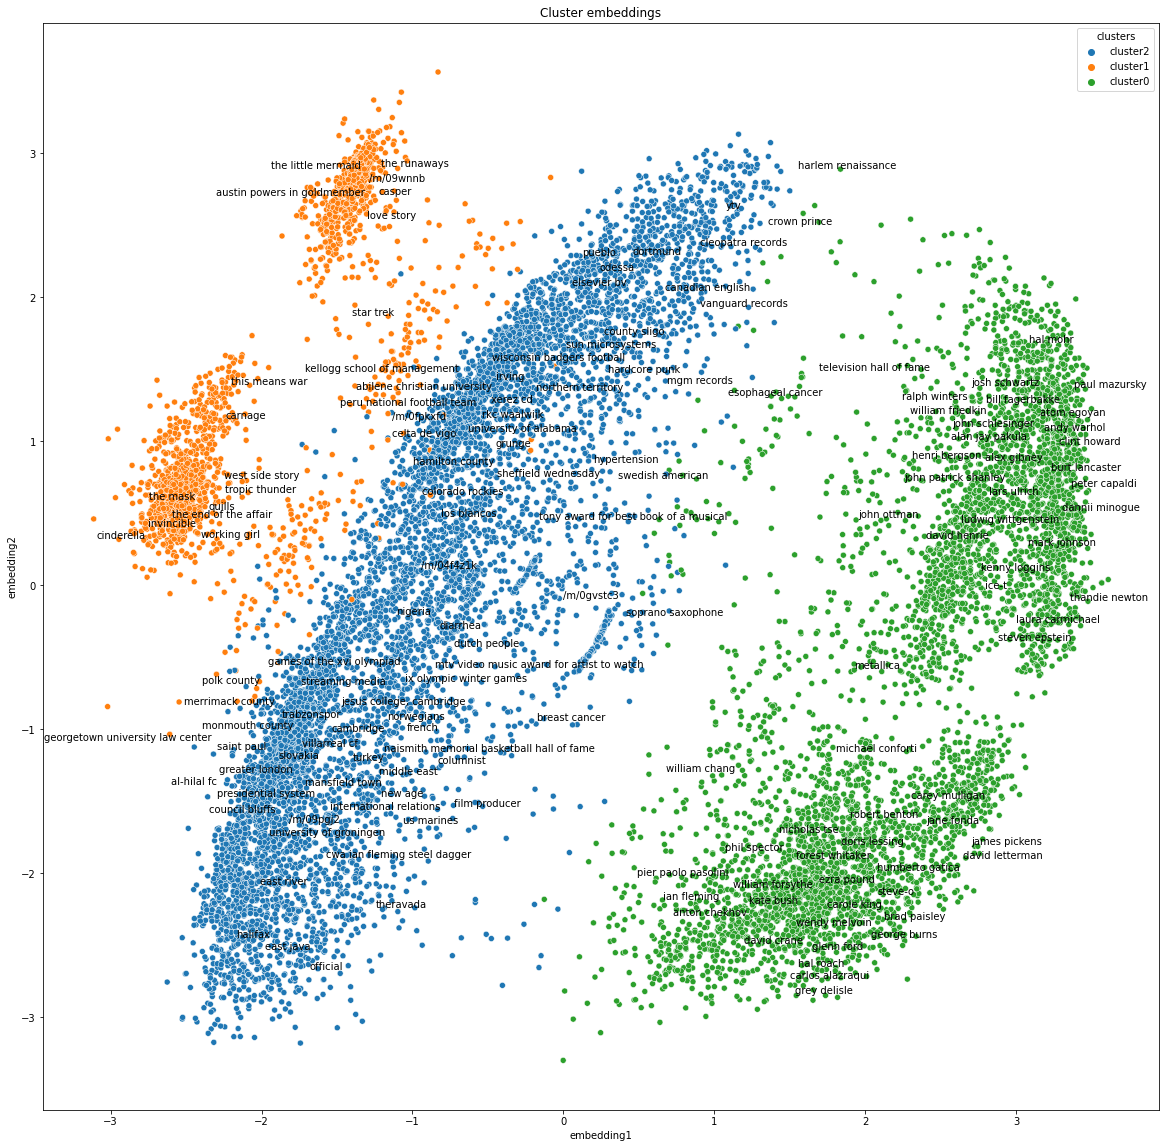

In [ ]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

# Get the embeddings (150 dims) for all the entities of interest
jobs_embeddings = model.get_embeddings(all_entities, embedding_type='e')

# Perform PCA and reduce the dims to 2
embeddings_2d = PCA(n_components=2).fit_transform(np.array([emb for emb in jobs_embeddings]))

# Create a dataframe to plot the embeddings using scatterplot
df = pd.DataFrame({"entities": all_entities, "clusters": "cluster" + pd.Series(clusters).astype(str),
                    "embedding1": embeddings_2d[:, 0], "embedding2": embeddings_2d[:, 1]})

plt.figure(figsize=(20, 20))
plt.title("Cluster embeddings")

ax = sns.scatterplot(data=df, x="embedding1", y="embedding2", hue="clusters")

# Print only a few labels, to avoid clutter, using adjust_text
from adjustText import adjust_text
texts = []
for i, point in df.iterrows():
    # randomly choose a few labels to be printed
    if np.random.uniform() < 0.01:
        texts.append(plt.text(point['embedding1']+.1, point['embedding2'], str(point['entities'])))
        
adjust_text(texts)
plt.show()

## 7.3 Hypothesis Generation

Other times you may wish to discover **any** potential new facts from an existing knowledge graph. This can be done using [discover_facts](https://docs.ampligraph.org/en/1.4.0/generated/ampligraph.discovery.discover_facts.html#ampligraph.discovery.discover_facts) API.

With a knowledge graph containing millions of entities the space of possible facts is huge, and evaluating all of them can take a very long time. In order to speed up this task we have implemented a number of sampling strategies. 

The strategies implemented include: 
>    ```entity_frequency```, ```graph_degree```, ```cluster_coefficient```, ```cluster_triangles```, ```cluster_squares```, ```random_uniform```, ```exhaustive```. 

Entities in all strategies excluding ```random_uniform```, ```exhaustive``` are sorted in ascending fashion, on the assumption that frequent or densely connected entities are less likely to have missing true statements.

The general procedure is to generate a set of candidate statements, and then rank them against a set of corruptions using the ```model.evaluate()``` function. 

A sampling weight is calculated for each entity using the specified strategy, and ```max_candidates``` are sampled to produce the candidate triple set. 

Candidates are then evaluated to obtain a rank, and triples that appear in the ```top_n``` ranked statements of evaluation procedure are returned as potentially true statements.
            


In [ ]:
from ampligraph.discovery import discover_facts

triples, ranks = discover_facts(dataset.values, 
                                model, 
                                top_n=500, 
                                max_candidates=500, 
                                strategy='cluster_triangles', 
                                target_rel='/people/person/profession', 
                                seed=0)

for triple, rank in zip(triples, ranks):
    print('Rank: {} \t {} '.format(rank, triple))


Rank: 301.0 	 ['louie' '/people/person/profession' 'musician'] 
Rank: 485.5 	 ['lead guitar' '/people/person/profession' 'bass guitar'] 


## 7.4 Duplicate detection

KGE models can be used for entity disambiguation. In the graph you may have multiple labels for same concept. Eg. B Obama, Obama, Barak obama, Barak, Barak o, etc. All these labels identify the same person. You can find duplicate entities or relations in the graph by looking at the embedding space. Two entities which are very close in the embedding space (can be specified as a hyperparameter) can be considered as duplicates. AmpliGraph provides the ``find_duplicates`` API to get the duplicates.

In [ ]:
import pandas as pd
import numpy as np
import re

# The IMDB dataset used here is part of the Movies5 dataset found on:
# The Magellan Data Repository (https://sites.google.com/site/anhaidgroup/projects/data)
import requests
url = 'http://pages.cs.wisc.edu/~anhai/data/784_data/movies5.tar.gz'
open('movies5.tar.gz', 'wb').write(requests.get(url).content)
import tarfile
tar = tarfile.open('movies5.tar.gz', "r:gz")
tar.extractall()
tar.close()

# Reading tabular dataset of IMDB movies and filling the missing values
imdb = pd.read_csv("movies5/csv_files/imdb.csv")
imdb["directors"] = imdb["directors"].fillna("UnknownDirector")
imdb["actors"] = imdb["actors"].fillna("UnknownActor")
imdb["genre"] = imdb["genre"].fillna("UnknownGenre")
imdb["duration"] = imdb["duration"].fillna("0")

# Creating knowledge graph triples from tabular dataset
imdb_triples = []

for _, row in imdb.iterrows():
    movie_id = "ID" + str(row["id"])
    directors = row["directors"].split(",")
    actors = row["actors"].split(",")
    genres = row["genre"].split(",")
    duration = "Duration" + str(int(re.sub("\D", "", row["duration"])) // 30)

    directors_triples = [(movie_id, "hasDirector", d) for d in directors]
    actors_triples = [(movie_id, "hasActor", a) for a in actors]
    genres_triples = [(movie_id, "hasGenre", g) for g in genres]
    duration_triple = (movie_id, "hasDuration", duration)

    imdb_triples.extend(directors_triples)
    imdb_triples.extend(actors_triples)
    imdb_triples.extend(genres_triples)
    imdb_triples.append(duration_triple)


imdb_triples = np.array(imdb_triples)

model = ScoringBasedEmbeddingModel(k=150,                                         # embedding size
                                   eta=5,                                         # number of corruptions to generate during training
                                   scoring_type='ComplEx',                         # Scoring Function name
                                   seed=0)                                        # Random generator seed

optim = tf.keras.optimizers.Adam(learning_rate=0.001)

# compile the model with loss and optimizer
model.compile(optimizer=optim, 
              loss='multiclass_nll',
              entity_relation_initializer='glorot_normal',
              entity_relation_regularizer='L2')

model.fit(imdb_triples, epochs=200, batch_size=10000)

from ampligraph.discovery import find_duplicates
entities = np.unique(imdb_triples[:, 0])
dups, _ = find_duplicates(entities, model, mode='e', tolerance=0.4)


Epoch 1/200
7/7 [==============================] - 1s 182ms/step - loss: 15617.8115
Epoch 2/200
7/7 [==============================] - 0s 53ms/step - loss: 15615.8799
Epoch 3/200
7/7 [==============================] - 0s 53ms/step - loss: 15614.2393
Epoch 4/200
7/7 [==============================] - 0s 52ms/step - loss: 15612.4180
Epoch 5/200
7/7 [==============================] - 0s 51ms/step - loss: 15609.9834
Epoch 6/200
7/7 [==============================] - 0s 51ms/step - loss: 15606.4668
Epoch 7/200
7/7 [==============================] - 0s 50ms/step - loss: 15601.3486
Epoch 8/200
7/7 [==============================] - 0s 54ms/step - loss: 15594.0000
Epoch 9/200
7/7 [==============================] - 0s 52ms/step - loss: 15583.7100
Epoch 10/200
7/7 [==============================] - 0s 52ms/step - loss: 15569.7275
Epoch 11/200
7/7 [==============================] - 0s 51ms/step - loss: 15551.1533
Epoch 12/200
7/7 [==============================] - 0s 51ms/step - loss: 15527.0020


In [ ]:
print(list(dups)[:3])

print(imdb[imdb.id.isin((1101, 1102, 2523, 2522, 4359, 4360))][['movie_name', 'year']])


[frozenset({'ID1101', 'ID1102'}), frozenset({'ID2523', 'ID2522'}), frozenset({'ID4359', 'ID4360'})]
                movie_name  year
1101  Last Flight to Abuja  2012
1102  Last Flight to Abuja  2012
2522      Pros and Ex-Cons  2005
2523      Pros and Ex-Cons  2005
4359              Timebomb  1991
4360              Timebomb  1991


---
# 8. Visualizing embeddings using Tensorboard


Tensorboard Projector allows us to visualize high dimensional embeddings in a graphical interface. This can be useful to examine and understand embedded concepts. 

Ampligraph provides a single function for creating the Tensorboard files, [create_tensorboard_visualizations](), as demonstrated below.


In [ ]:
from ampligraph.utils import create_tensorboard_visualizations

create_tensorboard_visualizations(model, 'embeddings_transe')

Run the cell below to run tensorboard, and it will open in a different browser window with the tensorboard interface.

In [ ]:
# This will not work in google colab - only uncomment and run if using jupyter notebook 

# ! tensorboard --logdir='./embeddings_transe'

# Appendix




**Assume you are incrementally building knowledge graphs and training models in phases. Can you compare the models trained on these incremental datasets?**

Depends. You should have the same test set and same number of corruptions when you want to compare models. If you are only adding new links incrementally, it does not matter. The models would be comparable. However, if you are also adding new concepts, then you must be careful while evaluating the models. You must make sure that the number of corruptions generated are the same throughout. You can choose a set of entities that would be used as corruptions in all the phases and then use `entities_subset` argument of `model.evaluate` API.


**What if my embedding matrices are not fitting on the GPU?**

Sometime while running the model, you may run into ResourceExhausted error on the GPU, especially because the batches may not fit in memory. This can usually be solved by decreasing the batch size. 

There are times when you may have millions of entities in the graph, and you may not be able to allocate the embedding matrix on the GPU. You would need to partition the graph and then train the models on the partitions. In Ampligraph 2, this is quite straignt forward. One can use the `partitioning_k` argument of `model.fit` and specify the number of partitions to create. By default this is set to 1, but if the user overrides this, the dataset will be partitioned using Bucket based partitioning and the model will be trained on these data partitions.